In [ ]:
%%bash
python -m spacy download en
pip install python_minifier autopep8

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


### Importing Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator, LabelField, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
import python_minifier
import io
import tokenize
import re
import autopep8
from sklearn.model_selection import train_test_split
import pandas as pd


SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preparing Data

In [ ]:
code_list = [[]]
filename = '/content/data_cleaned_tabs_only.txt'

with open(filename) as f:
  for line in f:
    if line.startswith('#'):
      comment = line.split('\n#')
      if code_list[-1] != []:
        # Now we are in a new block
        code_list.append(comment)
    else:
      stripped_line = line#.strip()
      if stripped_line:
        code_list[-1].append(stripped_line)       

In [ ]:
raw_data_dict = {'Description' : [re.sub(r"^#(\d)*",'',x[0]).strip() for x in code_list], 'Code': [''.join(x[1:]) for x in code_list]}
df = pd.DataFrame(raw_data_dict, columns=["Description", "Code"])

In [ ]:
df['Description'][1617]

'two numbers are anagram'

In [ ]:
df['Code'][1617]

"\n\nfrom collections import Counter\n\ndef checkAnagram(num1, num2):\n\tbin1=bin(num1)[2:]\n\tbin2=bin(num2)[2:]\n\n\tzeros=abs(len(bin1) - len(bin2))\n\tif (len(bin1) > len(bin2)):\n\t\t bin2=zeros * '0' + bin2\n\telse:\n\t\t bin1=zeros * '0' + bin1\n\n\tdict1=Counter(bin1)\n\tdict2=Counter(bin2)\n\n\n\n\tif dict1 == dict2:\n\t\t print('Yes')\n\telse:\n\t\t print('No')\n\n\n"

In [ ]:
df.head()

,Description,Code
0,,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provid...,"\n\ndef add_two_numbers(num1, num2):\n\tsum = ..."
2,write a program to find and print the largest ...,\n\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 ...
3,write a program to find and print the smallest...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <=...
4,Write a python function to merge two given lis...,"\n\ndef merge_lists(l1, l2):\n\treturn l1 + l2..."


In [ ]:
def fix_py(code):
  '''
  Fixing the raw code obtained by using autopep8 library
  '''
  code = autopep8.fix_code(code, options={'ignore': ['E402']})
  io_obj = io.StringIO(code)
  res = []
  prev_toktype = tokenize.INDENT
  last_lineno = -1
  last_col = 0
  for tok in tokenize.generate_tokens(io_obj.readline):
      token_type = tok[0]
      token_string = tok[1]
      start_line, start_col = tok[2]
      end_line, end_col = tok[3]
      ltext = tok[4]
      if start_line > last_lineno:
          last_col = 0
      if start_col > last_col:
          res.append(" " * (start_col - last_col))
      if token_type == tokenize.COMMENT:
          pass
      elif token_type == tokenize.STRING:
          if prev_toktype != tokenize.INDENT:
              if prev_toktype != tokenize.NEWLINE:
                  if start_col > 0:
                      res.append(token_string)
      else:
          res.append(token_string)
      prev_toktype = token_type
      last_col = end_col
      last_lineno = end_line
  res = ['\t' if a == '    ' else a for a in res]
  return res

In [ ]:
from tqdm.auto import tqdm

df_final = pd.DataFrame()
for _, row in tqdm(df.iterrows()):
    code = fix_py(code=row['Code'])
    
    if code:
        row['Code'] = ''.join(a for a in code)
        df_final = df_final.append(row)

In [ ]:
df_final.head()

,Code,Description
0,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...,
1,"\n\ndef add_two_numbers(num1, num2):\n\tsum = ...",write a python function to add two user provid...
2,\n\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 ...,write a program to find and print the largest ...
3,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <=...,write a program to find and print the smallest...
4,"\n\ndef merge_lists(l1, l2):\n\treturn l1 + l2\n",Write a python function to merge two given lis...


Dropping all NaN values

In [ ]:
df_final.dropna(subset = ["Code"], inplace=True)

In [ ]:
df_final=df_final[['Description', 'Code']]

Replacing all tabs, new line and space characters with TAB, NL, SPC

In [ ]:
df_final['Code']=df_final['Code'].str.replace('\t', '<TAB>')
df_final['Code']=df_final['Code'].str.replace('\n', '<NL>')
df_final['Code']=df_final['Code'].str.replace(' ', '<SPC>')

Getting all the lengths of each code, and limiting the max length to 2000

In [ ]:
for key, value in df_final['Code'].iteritems():
    if int(len(df_final['Code'][key])) > 2000 :

      print(key, int(len(df_final['Code'][key])))

813 2015
1718 2521
4882 5069


In [ ]:
df_final['len'] = df_final['Code'].str.len()
df_final = df_final.drop(df_final[df_final['len'] == 0].index)
df_final = df_final[df_final['len'] < 2000]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Sorting the codes based on the code length

In [ ]:
df_final = df_final.sort_values(by='Description', key=lambda x:x.str.len())

Checking for '\t' if it exits still

In [ ]:
df_final[df_final['Code'].str.contains('\t')]

,Description,Code,len
4793,80],"\n\na = [10, 20, 30, 20, 10, 50, 60, 40, 80, 5...",193
1882,s='',for i in test_list:\n\ts = ''\n\tfor j in i:\n...,84
6135,list.,"import math\n\n\ndef bin_search(li, element):\...",431
1937,of 4.,def reverse_string(str1):\n\tif len(str1) % 4 ...,102
6055,keys.,def printDict():\n\td = dict()\n\tfor i in ran...,83
...,...,...,...
1446,Write a Python function to find the N-th numbe...,def nth_sq_and_cube(N):\n\tR = N**6\n\treturn R\n,44
2128,write a Python function that returns the deter...,def determinant(A):\n\tif len(A) == 1:\n ...,409
3006,write a python program to count how many times...,string = 'The quick brown fox jumps over the l...,220
4404,Write a Python function to find the N-th numbe...,def nth_sq_and_cube(N):\n\tR = N**6\n\treturn R\n,44


Removing len column since it's not needed now 

In [ ]:
del df_final['len']

In [ ]:
df_final

,Description,Code
0,,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
5199,it,"li = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]\nevenNumb..."
5027,or,x = [[[value1]]] \n
1255,or,x = [[[value1]]] \n
4793,80],"\n\na = [10, 20, 30, 20, 10, 50, 60, 40, 80, 5..."
...,...,...
4414,Write a Python program to print euclidean dist...,"import numpy as np\na = np.array([78, 84, 87, ..."
4404,Write a Python function to find the N-th numbe...,def nth_sq_and_cube(N):\n\tR = N**6\n\treturn R\n
5950,write Python code to demonstrate to remove the...,"\n\nini_tuple = [('b', 100), ('c', 200), ('c',..."
5657,"8 write a python function to accept a key, val...","\n\ndef create_dictionary(key, value):\n\tretu..."


### Splitting the dataset into train and test

In [ ]:
train, test = train_test_split(df_final, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train.to_csv('train.tsv', index=False, sep='\t')

In [ ]:
test.to_csv('test.tsv', index=False, sep='\t')

### Loading train and valid tab separated files as dataframes

In [ ]:
train_df = pd.read_csv('/content/train.tsv', sep='\t')
test_df = pd.read_csv('/content/test.tsv', sep='\t')

In [ ]:
train_df.head()

,Description,Code
0,Concatenation of two List,"my_list1 = [4, 3, 2, 9, 10, 44, 1]\nmy_list2 =..."
1,Calculate the length of dictionary,"thisdict = {\n\t""brand"": ""Ford"",\n\t""model"": ""..."
2,write a python function to calculate age given...,\n\nfrom datetime import date\n\n\ndef calcula...
3,write Python program to illustrate enumerate ...,"l1 = [""eat"", ""sleep"", ""repeat""]\n\n\nfor count..."
4,is odd,"def add_even_odd_list(l1: list, l2: list) -> l..."


In [ ]:
test_df.head()

,Description,Code
0,Write a python function to remove duplicates f...,\n\ndef remove_duplicates(lista):\n\tlista2 = ...
1,join using a - hyphen.,def word_join(s):\n\twords = s.split(' ')\n\tr...
2,write a function to find out the second maximu...,def find_second_maximum(lst):\n\tmax = float('...
3,Concatenation of two List,"my_list1 = [4, 3, 2, 9, 10, 44, 1]\nmy_list2 =..."
4,date of birth,"\n\ndef zodiac_sign(day, month):\n\n\tif month..."


Getting some info on daataframe

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3543 entries, 0 to 3542
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  3542 non-null   object
 1   Code         3543 non-null   object
dtypes: object(2)
memory usage: 55.5+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  886 non-null    object
 1   Code         886 non-null    object
dtypes: object(2)
memory usage: 14.0+ KB


In [ ]:
spacy_en = spacy.load('en')

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
def tokenizerpy(source):
  '''
  Tokenizes and fixes python code
  '''
  source = autopep8.fix_code(source,
                                options={'ignore': ['E402']})
  io_obj = io.StringIO(source)
  out = []
  prev_toktype = tokenize.INDENT
  last_lineno = -1
  last_col = 0
  for tok in tokenize.generate_tokens(io_obj.readline):
      token_type = tok[0]
      token_string = tok[1]
      start_line, start_col = tok[2]
      end_line, end_col = tok[3]
      ltext = tok[4]
      if start_line > last_lineno:
          last_col = 0
      if start_col > last_col:
          out.append(" " * (start_col - last_col))
      if token_type == tokenize.COMMENT:
          pass
      elif token_type == tokenize.STRING:
          if prev_toktype != tokenize.INDENT:
              if prev_toktype != tokenize.NEWLINE:
                  if start_col > 0:
                      out.append(token_string)
      else:
          out.append(token_string)
      prev_toktype = token_type
      last_col = end_col
      last_lineno = end_line
  out = ['\t' if a == '    ' else a for a in out]
  return out

In [ ]:
def tokenize_py(code):
    ''' Custom Python tokenizer that tokenizes python code '''
    code = code.replace('<TAB>', '\t')
    tokens = tokenizerpy(code)
    return tokens


### Setting up the field datatypes

In [ ]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_py, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False, 
            batch_first = True)
fields = [('Description', SRC),('Code',TRG)]


### Creating the Dataset

In [ ]:
train_data, test_data = TabularDataset.splits(
                                path = '',   
                                train = 'train.tsv',
                                test = 'test.tsv',
                                skip_header = True,
                                format = 'tsv',
                                fields = fields)

In [ ]:
print(' '.join(_ for _ in vars(train_data.examples[1000])['Description']))

write a python program uses else with for loop


In [ ]:
print(''.join(_ for _ in vars(train_data.examples[1000])['Code']))

seq = "abcde"
for k in seq:
	if k == "f":
	break
else:
	print("f Not Found!")



##Setting up the *device*

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Building the vocabulary

In [ ]:
SRC.build_vocab(train_data, min_freq = 1, max_size= 10000)
TRG.build_vocab(train_data, min_freq = 1,max_size= 10000)

In [ ]:
len(SRC.vocab), len(TRG.vocab)

(1714, 5750)

In [ ]:
BATCH_SIZE = 24

train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.Description),
    device = device)

### Saving the Vocabulary

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(SRC.vocab.stoi, tokens)

## Model

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]


        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]        
        return output, attention

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 2000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
 
            
        return src

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 2000):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 2
DEC_LAYERS = 2
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)


dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT,
              device)

## Training the Seq2Seq Model

The rest of this session is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,048,310 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(1714, 256)
    (pos_embedding): Embedding(2000, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
    

### Optimizer

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

### Using CrossEntropyLoss as the loss function

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

## Training and Evaluation

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.Description
        trg = batch.Code
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])

                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]

            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        #loss = maskNLLLoss(output, trg,model.trg_pad_idx)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.Description
            trg = batch.Code

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
           
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            
            loss = criterion(output, trg)
            #loss = maskNLLLoss(output, trg,model.trg_pad_idx)

            #loss,_ = maskNLLLoss(output, trg, mask)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Function to get the elapsed time

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
N_EPOCHS = 40
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 10s
	Train Loss: 3.422 | Train PPL:  30.643
	 Val. Loss: 2.405 |  Val. PPL:  11.077
Epoch: 02 | Time: 0m 10s
	Train Loss: 2.194 | Train PPL:   8.973
	 Val. Loss: 2.075 |  Val. PPL:   7.968
Epoch: 03 | Time: 0m 11s
	Train Loss: 1.885 | Train PPL:   6.585
	 Val. Loss: 1.882 |  Val. PPL:   6.569
Epoch: 04 | Time: 0m 10s
	Train Loss: 1.661 | Train PPL:   5.267
	 Val. Loss: 1.733 |  Val. PPL:   5.658
Epoch: 05 | Time: 0m 11s
	Train Loss: 1.476 | Train PPL:   4.374
	 Val. Loss: 1.633 |  Val. PPL:   5.118
Epoch: 06 | Time: 0m 11s
	Train Loss: 1.316 | Train PPL:   3.729
	 Val. Loss: 1.543 |  Val. PPL:   4.681
Epoch: 07 | Time: 0m 11s
	Train Loss: 1.174 | Train PPL:   3.236
	 Val. Loss: 1.466 |  Val. PPL:   4.333
Epoch: 08 | Time: 0m 11s
	Train Loss: 1.057 | Train PPL:   2.878
	 Val. Loss: 1.418 |  Val. PPL:   4.129
Epoch: 09 | Time: 0m 11s
	Train Loss: 0.953 | Train PPL:   2.594
	 Val. Loss: 1.365 |  Val. PPL:   3.915
Epoch: 10 | Time: 0m 11s
	Train Loss: 0.860 | Train PPL

### Loading the model and evaluating the outputs

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.286 | Test PPL:   3.618 |


### Function to translate the input English sentence and feeding it to the model

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 100):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    # print('tokens for trans :', tokens)
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor,src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
input_id = 12

src = vars(train_data.examples[input_id])['Description']
trg = vars(train_data.examples[input_id])['Code']

print(f'source_sentence = {src}')
print(f'target_sentence = {trg}')
print(''.join(trg))

source_sentence = ['write', 'a', 'python', 'function', 'to', 'generate', 'sha256', 'for', 'given', 'text']
target_sentence = ['def', ' ', 'get_sha256', '(', 'text', ')', ':', '\n', '\t', 'import', ' ', 'hashlib', '\n', '\t', 'return', ' ', 'hashlib', '.', 'sha256', '(', 'text', ')', '.', 'hexdigest', '(', ')', '\n', '', '']
def get_sha256(text):
	import hashlib
	return hashlib.sha256(text).hexdigest()



In [ ]:
# sentence = "write a program to add two numbers"
code, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted target = {code}\n')

print("*"*44)
print("Predicted Code: ")
code = "".join(code[:-1]) if code[-1] == '<eos>' else "".join(code)
print(code)



predicted target = ['def', ' ', 'cal_sp_after_discount', '(', 'sp', ':', ' ', 'float', ',', ' ', 'discount', ':', ' ', 'float', ')', ' ', '->', ' ', 'float', ':', '\n', '\t', 'return', ' ', 'sp', ' ', '*', ' ', '(', '1', ' ', '-', ' ', 'discount', ' ', '/', ' ', '100', ')', '\n', '', '', '<eos>']

********************************************
Predicted Code: 
def cal_sp_after_discount(sp: float, discount: float) -> float:
	return sp * (1 - discount / 100)



## Prediction of 25 Examples



In [ ]:
for input_id in random.choices(range(len(train_data)), k=25):
    src = vars(train_data.examples[input_id])['Description']
    trg = vars(train_data.examples[input_id])['Code']
    print('*'*88)
    print(' '.join(src), '\n')
    print('*'*44, 'Given Solution', '*'*44,)
    print(''.join(trg))
    print('*'*44, 'Predicted Solution', '*'*44)
    code, attention = translate_sentence(src, SRC, TRG, model, device)
    code = "".join(code[:-1]) if code[-1] == '<eos>' else "".join(code)
    print(code)

****************************************************************************************
write a python program to check and print if a number is prime 

******************************************** Given Solution ********************************************
num = 407
if num > 1:
	for i in range(2, num):
	if (num % i) == 0:
        print(num, "is not a prime number")
        break
	else:
        print(num, "is a prime number")
else:
	print(num, "is not a prime number")

******************************************** Predicted Solution ********************************************


num = 407


if num > 1:
	for i in range(2, num):
	if (num % i == 0):
        print(num, "is not a prime number")
        print(num, "times", num // i, i, i, i, i, i, i)
        break
	else
****************************************************************************************
comprehension 

******************************************** Given Solution ********************************************


l_range = 2
u

## Display Attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

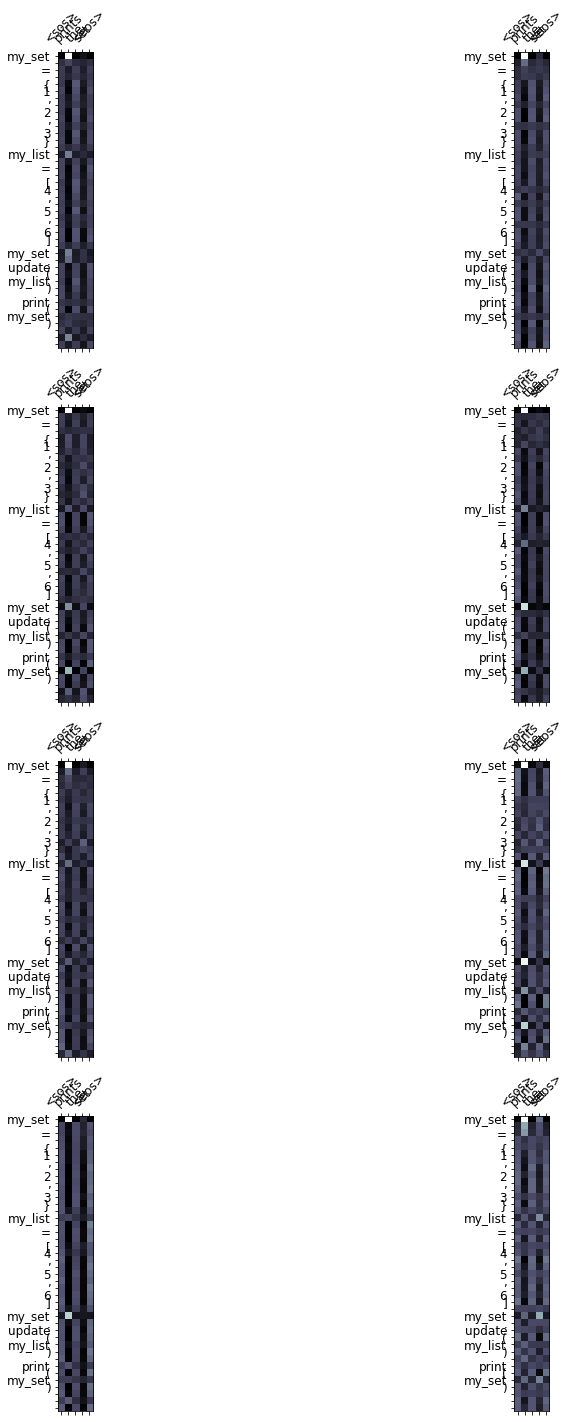

In [ ]:
display_attention(src, trg, attention)

# BLEU Score

The Bilingual Evaluation Understudy Score, or BLEU for short is a method for automatic evaluation of machine translation. BLEU is a score for comparing/evaluating a candidate translation (translated sentence) of text to one or more reference translation (ground truth). 
It is based on "text string matches" i.e it quantifies how good a machine translation by computing a similarity score based on ngram precision.

BLEU score can also be used to evalutate a wide range of text generation NLP tasks like language generation, image caption generation, text summarization etc.

Few benefits of BLEU score:
  - Quick and inexpensive to calculate
  - easy to understand
  - language independent


BLEU metrics ranges from 0 to 1. The higher the BLEU Score the better.



In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['Description']
        trg = vars(datum)['Code']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

IndexError: ignored